# 07 — Test Evaluation

Evaluates the best model on the held-out test set:
- Classification metrics (confusion matrix, ROC, calibration)
- Portfolio simulation (3 ML strategies + MACD baseline + DCA)

In [1]:
import sys
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

PROJECT_FOLDER = "spy_run"
PROJECT_ROOT = Path(os.getcwd()).parent
sys.path.insert(0, str(PROJECT_ROOT))
os.chdir(PROJECT_ROOT)

DATA_CONFIG = PROJECT_ROOT / "config" / PROJECT_FOLDER / "data_config.json"
MODEL_CONFIG = PROJECT_ROOT / "config" / PROJECT_FOLDER / "model_config.json"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed" / PROJECT_FOLDER
MODELS_DIR = PROJECT_ROOT / "models" / PROJECT_FOLDER
RESULTS_DIR = PROJECT_ROOT / "results" / PROJECT_FOLDER
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

from src.utils.config_loader import ConfigLoader
config = ConfigLoader(str(DATA_CONFIG), str(MODEL_CONFIG))
sns.set_theme(style="whitegrid")
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"]   = "white"
plt.rcParams["savefig.facecolor"] = "white"
print(f"Project folder: {PROJECT_FOLDER}")

Project folder: spy_run


In [2]:
# Load test data and model
test_df = pd.read_parquet(PROCESSED_DIR / "test.parquet")
with open(PROCESSED_DIR / "metadata.json") as f:
    metadata = json.load(f)
with open(MODELS_DIR / "model_metadata.json") as f:
    model_meta = json.load(f)

model_path = MODELS_DIR / "best_model.pkl"
with open(model_path, "rb") as f:
    model = pickle.load(f)

feature_cols = model_meta["feature_cols"]
best_model_name = model_meta["best_model_name"]

print(f"Test shape      : {test_df.shape}")
print(f"Best model      : {best_model_name}")
print(f"Test date range : {test_df.index[0].date()} to {test_df.index[-1].date()}")

Test shape      : (502, 14)
Best model      : random_forest
Test date range : 2024-02-13 to 2026-02-12


In [3]:
X_test = test_df[feature_cols].values
y_true = test_df["target"].values
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(f"Predictions: {len(y_pred)}")
print(f"Predicted 1 (up): {y_pred.sum()} ({y_pred.mean()*100:.1f}%)")
print(f"Actual 1 (up)   : {y_true.sum()} ({y_true.mean()*100:.1f}%)")

Predictions: 502
Predicted 1 (up): 114 (22.7%)
Actual 1 (up)   : 51 (10.2%)


## Classification Metrics

In [4]:
from src.evaluation.metrics import ClassificationMetrics

evaluator = ClassificationMetrics()
metrics = evaluator.compute(y_true, y_pred, y_prob)
print("Test Set Metrics:")
for k, v in metrics.items():
    print(f"  {k:12s}: {v:.4f}")

with open(RESULTS_DIR / "test_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

Test Set Metrics:
  accuracy    : 0.8108
  precision   : 0.3070
  recall      : 0.6863
  f1          : 0.4242
  roc_auc     : 0.8122


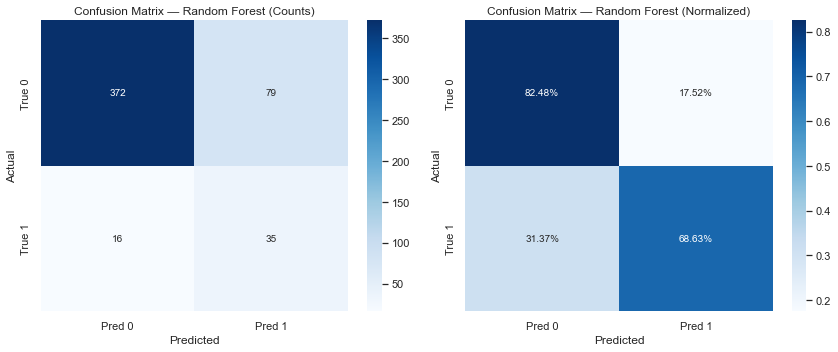

In [5]:
fig = evaluator.plot_confusion_matrix(
    y_true, y_pred,
    title=f"Confusion Matrix — {best_model_name.replace('_', ' ').title()}",
    save_path=str(RESULTS_DIR / "confusion_matrix.png")
)
plt.show()

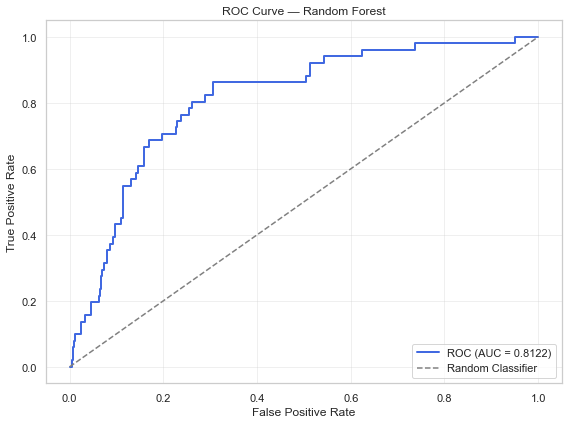

In [6]:
fig = evaluator.plot_roc_curve(
    y_true, y_prob,
    title=f"ROC Curve — {best_model_name.replace('_', ' ').title()}",
    save_path=str(RESULTS_DIR / "roc_curve.png")
)
plt.show()

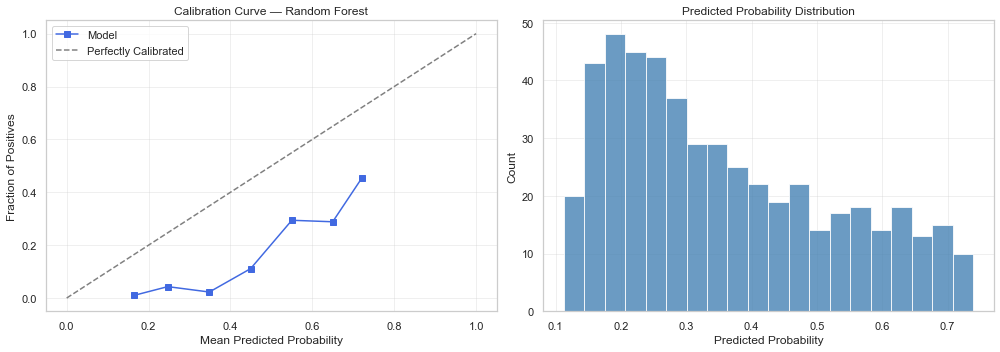

In [7]:
fig = evaluator.plot_calibration_curve(
    y_true, y_prob,
    title=f"Calibration Curve — {best_model_name.replace('_', ' ').title()}",
    save_path=str(RESULTS_DIR / "calibration_curve.png")
)
plt.show()

## Portfolio Simulation

In [8]:
from src.evaluation.portfolio import PortfolioSimulator

# Load raw (unnormalized) close prices for portfolio simulation
# Rolling normalization changes price levels — portfolio needs actual dollar prices
raw_combined_path = PROJECT_ROOT / "data" / "raw" / f"{PROJECT_FOLDER}_raw.parquet"
if raw_combined_path.exists():
    raw_all = pd.read_parquet(raw_combined_path)
    if "Adj_Close" in raw_all.columns:
        raw_all["Close"] = raw_all["Adj_Close"]
    portfolio_df = raw_all.loc[raw_all.index.isin(test_df.index), ["Close"]].copy()
else:
    print("Warning: raw parquet not found — using normalized Close prices")
    portfolio_df = test_df[["Close"]].copy()

print(f"Portfolio test data : {portfolio_df.shape}")
print(f"Price range         : ${portfolio_df['Close'].min():.2f} to ${portfolio_df['Close'].max():.2f}")

Portfolio test data : (502, 1)
Price range         : $482.16 to $695.49


In [9]:
from ta.trend import MACD as MACD_Indicator

simulator = PortfolioSimulator(config)

# Align y_prob with portfolio_df index
portfolio_df = portfolio_df.loc[portfolio_df.index.isin(test_df.index)]
prob_series = pd.Series(y_prob, index=test_df.index)
prob_aligned = prob_series.reindex(portfolio_df.index).fillna(0.5).values

# Compute raw MACD histogram from unscaled prices for baseline comparison
macd_ind = MACD_Indicator(close=portfolio_df["Close"])
macd_hist = macd_ind.macd_diff().fillna(0).values

results = simulator.simulate(portfolio_df, prob_aligned, macd_hist=macd_hist)


  Simulating strategy_1_threshold_0.5...
  Simulating strategy_2_threshold_0.6...
  Simulating strategy_3_variable_shares...
  Simulating macd_strategy...
  Simulating dca_weekly...
  Simulating dca_monthly...


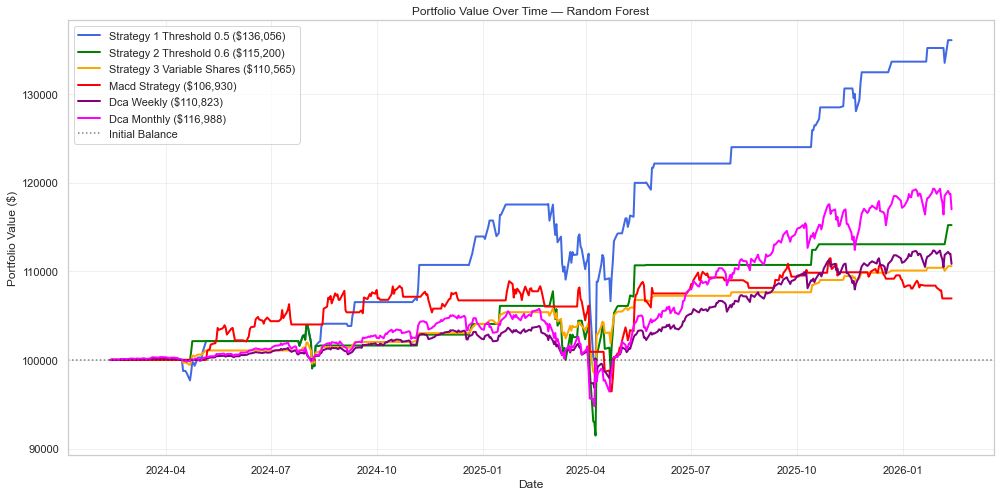

In [10]:
fig = simulator.plot_portfolio_values(
    portfolio_df,
    results,
    title=f"Portfolio Value Over Time — {best_model_name.replace('_', ' ').title()}",
    save_path=str(RESULTS_DIR / "portfolio_values.png")
)
plt.show()

## Strategy Comparison

In [11]:
comparison_table = simulator.comparison_table(results)
print("Strategy Comparison:")
print(comparison_table.to_string())

comparison_table.to_csv(RESULTS_DIR / "strategy_comparison.csv")

Strategy Comparison:
                            initial_balance  final_value  total_return_pct  sharpe_ratio  max_drawdown_pct  n_trades  win_rate_pct
Strategy                                                                                                                          
Strategy 1 Threshold 0.5             100000    136055.50             36.06        1.0987            -16.24       114         64.04
Strategy 2 Threshold 0.6             100000    115200.11             15.20        0.4864            -15.10        63         63.49
Strategy 3 Variable Shares           100000    110565.13             10.57        0.5468             -7.57       114         64.04
Macd Strategy                        100000    106929.78              6.93        0.2064            -11.40       227         56.83
Dca Weekly                           100000    110823.45             10.82        0.5784             -6.72       101         91.09
Dca Monthly                          100000    116988.35      

In [12]:
# Save all test results
test_results = {
    "model": best_model_name,
    "classification_metrics": metrics,
    "portfolio_summaries": {name: res["summary"] for name, res in results.items()},
}
with open(RESULTS_DIR / "test_results.json", "w") as f:
    json.dump(test_results, f, indent=2)

print("\nAll results saved to:", RESULTS_DIR)
print("Files:")
for f in sorted(RESULTS_DIR.iterdir()):
    print(f"  {f.name}")


All results saved to: /Users/sharannaribole/Documents/github/stock-return-classifier/results/spy_run
Files:
  baseline_comparison.png
  baseline_results.json
  calibration_curve.png
  confusion_matrix.png
  eda_class_distribution.png
  eda_correlation_heatmap.png
  eda_feature_distributions.png
  eda_feature_target_correlation.png
  eda_mutual_information.png
  eda_recommendations.json
  eda_time_series.png
  fe_log1p_distributions.png
  learning_curves.png
  model_comparison.png
  portfolio_values.png
  roc_curve.png
  strategy_comparison.csv
  test_metrics.json
  test_results.json
  validation_results.json


In [13]:
# ── Load reference values from saved files ───────────────────────────────────
with open(RESULTS_DIR / "baseline_results.json") as f:
    _baseline = json.load(f)
with open(RESULTS_DIR / "validation_results.json") as f:
    _val = json.load(f)

MACD_F1     = _baseline["macd_momentum"]["f1"]
MACD_PREC   = _baseline["macd_momentum"]["precision"]
MACD_RECALL = _baseline["macd_momentum"]["recall"]

_bvm        = _val["best_model_val_metrics"]
VAL_PRECISION = _bvm["precision"]
VAL_RECALL    = _bvm["recall"]
VAL_F1        = _bvm["f1"]
VAL_ROC_AUC   = _bvm["roc_auc"]

ticker = config.get("ticker") or "?"

# ── Compute actual next-day returns for FP analysis ──────────────────────────
raw_close = portfolio_df["Close"].values
next_day_return = np.full(len(raw_close), np.nan)
next_day_return[:-1] = (raw_close[1:] - raw_close[:-1]) / raw_close[:-1] * 100

fp_mask = (y_pred == 1) & (y_true == 0)
fp_returns = next_day_return[fp_mask]
fp_returns = fp_returns[~np.isnan(fp_returns)]  # drop last-day NaN if any

n_fp_loss    = int((fp_returns < 0).sum())       # actual losses
n_fp_small   = int(((fp_returns >= 0) & (fp_returns < 1)).sum())  # positive but < 1%
n_fp_total   = len(fp_returns)
fp_loss_mean = float(fp_returns[fp_returns < 0].mean()) if n_fp_loss > 0 else 0.0
fp_gain_mean = float(fp_returns[fp_returns >= 0].mean()) if (n_fp_total - n_fp_loss) > 0 else 0.0

sep  = "═" * 70
sep2 = "-" * 50

print(sep)
print(f"  TEST EVALUATION — COMPREHENSIVE REPORT  ({ticker}, ≥1% 1-day)")
print(f"  Model: {best_model_name.replace('_',' ').title()}  |  Period: {test_df.index[0].date()} → {test_df.index[-1].date()}")
print(sep)

# ── 1. Prediction Summary ─────────────────────────────────────────────────────
n_days      = len(y_true)
n_actual_up = int(y_true.sum())
n_pred_up   = int(y_pred.sum())
n_true_pos  = int(((y_pred == 1) & (y_true == 1)).sum())
n_false_pos = int(((y_pred == 1) & (y_true == 0)).sum())
n_false_neg = int(((y_pred == 0) & (y_true == 1)).sum())
n_true_neg  = int(((y_pred == 0) & (y_true == 0)).sum())

print(f"\n1. PREDICTION BREAKDOWN  ({n_days} test days)")
print(sep2)
print(f"  Actual Up days (≥1% gain) : {n_actual_up:>4}  ({n_actual_up/n_days*100:.1f}%)")
print(f"  Predicted Up              : {n_pred_up:>4}  ({n_pred_up/n_days*100:.1f}%)")
print()
print(f"  True  Positives (correct buy signals) : {n_true_pos}")
print(f"  False Positives (wrong buy signals)   : {n_false_pos}  ← entered but didn't hit ≥1%")
print(f"  False Negatives (missed up days)      : {n_false_neg}")
print(f"  True  Negatives (correct no-trade)    : {n_true_neg}")

print(f"\n  FALSE POSITIVE BREAKDOWN:")
print(f"    Actual loss  (return < 0%)    : {n_fp_loss:>3} / {n_fp_total}  "
      f"({n_fp_loss/n_fp_total*100:.1f}%)  avg return = {fp_loss_mean:+.2f}%")
print(f"    Small gain   (0% ≤ ret < 1%)  : {n_fp_small:>3} / {n_fp_total}  "
      f"({n_fp_small/n_fp_total*100:.1f}%)")
print(f"    Avg return on profitable FPs  : {fp_gain_mean:+.2f}%")
print()
print(f"  Of the {n_false_pos} false positives, {n_fp_loss} resulted in actual losses —")
print(f"  these are the costly mistakes. The remaining {n_fp_total - n_fp_loss} still produced")
print(f"  positive returns (just below the ≥1% target), which is why win rate ({(n_fp_total - n_fp_loss + n_true_pos)/(n_true_pos + n_fp_total)*100:.0f}%)")
print(f"  is much higher than precision ({metrics['precision']*100:.0f}%).")

# ── 2. Classification Metrics ─────────────────────────────────────────────────
print(f"\n2. CLASSIFICATION METRICS")
print(sep2)
print(f"  {'Metric':<12} {'Validation':>11} {'Test':>8} {'Δ':>8}")
print(f"  {'-'*12} {'-'*11} {'-'*8} {'-'*8}")
for label, val_v, test_k in [
    ("Precision",  VAL_PRECISION, "precision"),
    ("Recall",     VAL_RECALL,    "recall"),
    ("F1",         VAL_F1,        "f1"),
    ("ROC-AUC",    VAL_ROC_AUC,   "roc_auc"),
]:
    tv = metrics[test_k]
    print(f"  {label:<12} {val_v:>11.4f} {tv:>8.4f} {tv-val_v:>+8.4f}")

print()
prec_delta = metrics["precision"] - VAL_PRECISION
prec_dir   = "held consistent" if abs(prec_delta) < 0.02 else ("improved" if prec_delta > 0 else "degraded")
print(f"  Precision {prec_dir} ({metrics['precision']:.4f} vs validation {VAL_PRECISION:.4f}).")
print(f"  Recall = {metrics['recall']:.4f} vs validation {VAL_RECALL:.4f}.")
print(f"  ROC-AUC = {metrics['roc_auc']:.4f} — {'improved' if metrics['roc_auc'] > VAL_ROC_AUC else 'slightly below'} vs validation ({VAL_ROC_AUC:.4f}).")
print()
print(f"  vs MACD Baseline — F1: {metrics['f1']:.4f} vs {MACD_F1:.4f} ({metrics['f1']-MACD_F1:+.4f})")
print(f"                     Precision: {metrics['precision']:.4f} vs {MACD_PREC:.4f} ({metrics['precision']-MACD_PREC:+.4f})")

# ── 3. Win Rate vs Precision ──────────────────────────────────────────────────
print(f"\n3. WIN RATE vs PRECISION — AN IMPORTANT DISTINCTION")
print(sep2)
s1_key = [r for r in comparison_table.index if "0.5" in r][0]
s1 = comparison_table.loc[s1_key]
print(f"  Precision  = {metrics['precision']:.4f} — fraction of buy signals with ≥1% next-day gain")
print(f"  Win rate   = {s1['win_rate_pct']:.2f}%  — fraction of trades where exit_price > entry_price (any gain)")
print()
print(f"  A trade wins if {ticker} closes higher than entry — even +0.1% counts.")
print(f"  Precision requires ≥1%. Win rate ({s1['win_rate_pct']:.1f}%) >> precision ({metrics['precision']*100:.1f}%).")

# ── 4. Portfolio Results ──────────────────────────────────────────────────────
print(f"\n4. PORTFOLIO RESULTS  (starting $100,000 | hold = 1 day for ML/MACD)")
print(sep2)
s2_key = [r for r in comparison_table.index if "0.6" in r][0]
s3_key = [r for r in comparison_table.index if "Variable" in r][0]
macd_key = [r for r in comparison_table.index if "Macd" in r][0]
dca_w_key = [r for r in comparison_table.index if "Dca Weekly" in r][0]
dca_m_key = [r for r in comparison_table.index if "Dca Monthly" in r][0]
s2 = comparison_table.loc[s2_key]
s3 = comparison_table.loc[s3_key]
macd_row = comparison_table.loc[macd_key]
dca_w = comparison_table.loc[dca_w_key]
dca_m = comparison_table.loc[dca_m_key]

best_return = comparison_table["total_return_pct"].max()
for name, row in comparison_table.iterrows():
    marker = " ◄ BEST" if row["total_return_pct"] == best_return else ""
    print(f"  {name}")
    print(f"    Return: {row['total_return_pct']:+.2f}%  Final: ${row['final_value']:>12,.2f}  "
          f"Sharpe: {row['sharpe_ratio']:.4f}  MaxDD: {row['max_drawdown_pct']:.2f}%  "
          f"Trades: {int(row['n_trades'])}  WinRate: {row['win_rate_pct']:.1f}%{marker}")

# ── 5. Strategy Analysis ──────────────────────────────────────────────────────
print(f"\n5. STRATEGY ANALYSIS")
print(sep2)
print(f"  Strategy 1 (prob > 0.5) — {int(s1['n_trades'])} trades, return {s1['total_return_pct']:+.2f}%")
print(f"  Sharpe {s1['sharpe_ratio']:.4f}, max drawdown {s1['max_drawdown_pct']:.2f}%.")
print()
print(f"  Strategy 2 (prob ≥ 0.6) — {int(s2['n_trades'])} trades, return {s2['total_return_pct']:+.2f}%")
print(f"  Fewer trades ({int(s2['n_trades'])} vs {int(s1['n_trades'])}) with similar win rate ({s2['win_rate_pct']:.1f}% vs {s1['win_rate_pct']:.1f}%).")
print()
s3_identical = abs(s3['total_return_pct'] - s1['total_return_pct']) < 0.01
if s3_identical:
    print(f"  Strategy 3 (variable sizing) — identical to Strategy 1.")
    print(f"  Probability distribution concentrated above 0.875 — most signals deploy 100%.")
else:
    s3_vs_s1 = s3['total_return_pct'] - s1['total_return_pct']
    print(f"  Strategy 3 (variable sizing) — {int(s3['n_trades'])} trades, return {s3['total_return_pct']:+.2f}%")
    print(f"  {'Outperforms' if s3_vs_s1 > 0 else 'Underperforms'} Strategy 1 by {s3_vs_s1:+.2f}%.")

# ── 5b. MACD vs ML strategies ────────────────────────────────────────────────
print()
print(f"  MACD Strategy — {int(macd_row['n_trades'])} trades, return {macd_row['total_return_pct']:+.2f}%")
s1_vs_macd = s1['total_return_pct'] - macd_row['total_return_pct']
print(f"  Strategy 1 {'beats' if s1_vs_macd > 0 else 'trails'} MACD by {s1_vs_macd:+.2f}% return,")
print(f"  Sharpe {s1['sharpe_ratio']:.4f} vs {macd_row['sharpe_ratio']:.4f}, "
      f"drawdown {s1['max_drawdown_pct']:.2f}% vs {macd_row['max_drawdown_pct']:.2f}%.")

# ── 5c. DCA comparison ───────────────────────────────────────────────────────
print()
print(f"  DCA Weekly  — {int(dca_w['n_trades'])} buy events, return {dca_w['total_return_pct']:+.2f}%")
print(f"  DCA Monthly — {int(dca_m['n_trades'])} buy events, return {dca_m['total_return_pct']:+.2f}%")
s1_vs_dca_w = s1['total_return_pct'] - dca_w['total_return_pct']
s1_vs_dca_m = s1['total_return_pct'] - dca_m['total_return_pct']
print(f"  Strategy 1 {'beats' if s1_vs_dca_w > 0 else 'trails'} DCA Weekly by {s1_vs_dca_w:+.2f}%, "
      f"{'beats' if s1_vs_dca_m > 0 else 'trails'} DCA Monthly by {s1_vs_dca_m:+.2f}%.")
print(f"  DCA is a passive benchmark — no model required, just periodic investing.")

print()
price_start = portfolio_df["Close"].iloc[0]
price_end   = portfolio_df["Close"].iloc[-1]
print(f"  {ticker} moved from ${price_start:.2f} to ${price_end:.2f} over {n_days} test days.")

# ── 6. Key Findings ───────────────────────────────────────────────────────────
print(f"\n6. KEY FINDINGS")
print(sep2)
overfit = metrics["precision"] < VAL_PRECISION - 0.05
print(f"  {'✗ Precision degraded' if overfit else '✓ No overfitting'} — precision {metrics['precision']:.4f} vs validation {VAL_PRECISION:.4f}.")
print(f"  {'✓' if metrics['roc_auc'] >= VAL_ROC_AUC else '~'} ROC-AUC {'improved' if metrics['roc_auc'] > VAL_ROC_AUC else 'held'} on test ({metrics['roc_auc']:.4f} vs {VAL_ROC_AUC:.4f}).")
best_strategy = comparison_table["total_return_pct"].idxmax()
best_ret = comparison_table["total_return_pct"].max()
print(f"  ✓ Best strategy: {best_strategy} — return {best_ret:+.2f}%, Sharpe {comparison_table.loc[best_strategy, 'sharpe_ratio']:.4f}.")
print(f"  ✓ {s1['win_rate_pct']:.0f}% win rate — model picks next-day direction correctly more often than not.")
fp_loss_pct = n_fp_loss / n_fp_total * 100 if n_fp_total > 0 else 0
print(f"  {'✗' if fp_loss_pct > 50 else '~'} {n_fp_loss}/{n_fp_total} false positives ({fp_loss_pct:.0f}%) resulted in actual losses (avg {fp_loss_mean:+.2f}%).")
s1_beats_macd = s1['total_return_pct'] > macd_row['total_return_pct']
print(f"  {'✓' if s1_beats_macd else '✗'} Strategy 1 {'beats' if s1_beats_macd else 'trails'} MACD baseline "
      f"({s1['total_return_pct']:+.2f}% vs {macd_row['total_return_pct']:+.2f}%).")
s1_beats_dca_w = s1['total_return_pct'] > dca_w['total_return_pct']
s1_beats_dca_m = s1['total_return_pct'] > dca_m['total_return_pct']
print(f"  {'✓' if s1_beats_dca_w else '✗'} Strategy 1 {'beats' if s1_beats_dca_w else 'trails'} DCA Weekly "
      f"({s1['total_return_pct']:+.2f}% vs {dca_w['total_return_pct']:+.2f}%).")
print(f"  {'✓' if s1_beats_dca_m else '✗'} Strategy 1 {'beats' if s1_beats_dca_m else 'trails'} DCA Monthly "
      f"({s1['total_return_pct']:+.2f}% vs {dca_m['total_return_pct']:+.2f}%).")
print(f"  ✗ Regime shift: only {y_true.mean()*100:.1f}% Up days in test vs ~{_baseline['majority_class']['accuracy']*100:.0f}% Down/flat in training.")

# ── 7. Training Implications — Asymmetric FP Cost ────────────────────────────
print(f"\n7. TRAINING IMPLICATIONS — ASYMMETRIC FALSE POSITIVE COST")
print(sep2)
print(f"  Current setup: binary cross-entropy treats all FPs equally.")
print(f"  Reality: an FP with -2% return is far worse than an FP with +0.5% return.")
print()
print(f"  Potential improvements (future work):")
print(f"  • Sample weighting: penalize training samples where actual return < 0%")
print(f"    more heavily than those with 0% ≤ return < 1%.")
print(f"  • Three-class target: Up (≥1%), Neutral (0% to 1%), Down (<0%) —")
print(f"    model learns to distinguish losses from near-misses.")
print(f"  • Custom XGBoost objective: asymmetric loss that scales FP penalty")
print(f"    by magnitude of actual loss.")
print(f"  • Post-hoc threshold tuning: raise probability threshold to reduce")
print(f"    loss-making FPs at the cost of some recall (Strategy 2 approach).")
print()
print(f"  Note: the portfolio simulation already captures this effect —")
print(f"  win rate and P&L reflect the true cost of each FP.")


══════════════════════════════════════════════════════════════════════
  TEST EVALUATION — COMPREHENSIVE REPORT  (SPY, ≥1% 1-day)
  Model: Random Forest  |  Period: 2024-02-13 → 2026-02-12
══════════════════════════════════════════════════════════════════════

1. PREDICTION BREAKDOWN  (502 test days)
--------------------------------------------------
  Actual Up days (≥1% gain) :   51  (10.2%)
  Predicted Up              :  114  (22.7%)

  True  Positives (correct buy signals) : 35
  False Positives (wrong buy signals)   : 79  ← entered but didn't hit ≥1%
  False Negatives (missed up days)      : 16
  True  Negatives (correct no-trade)    : 372

  FALSE POSITIVE BREAKDOWN:
    Actual loss  (return < 0%)    :  41 / 79  (51.9%)  avg return = -1.23%
    Small gain   (0% ≤ ret < 1%)  :  38 / 79  (48.1%)
    Avg return on profitable FPs  : +0.49%

  Of the 79 false positives, 41 resulted in actual losses —
  these are the costly mistakes. The remaining 38 still produced
  positive returns (